# Comparing a USGSCSM and ISIS camera for MRO CTX

In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Download Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2019-08-02 15:19:06--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243340224 (232M) [application/octet-stream]
Server file no newer than local file ‘data/K11_057871_1602_XN_19S163W.IMG’ -- not retrieving.



## Ingest the image and spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
with MroCtxPds3LabelNaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))

camera = knoten.csm.create_csm(fileName)

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

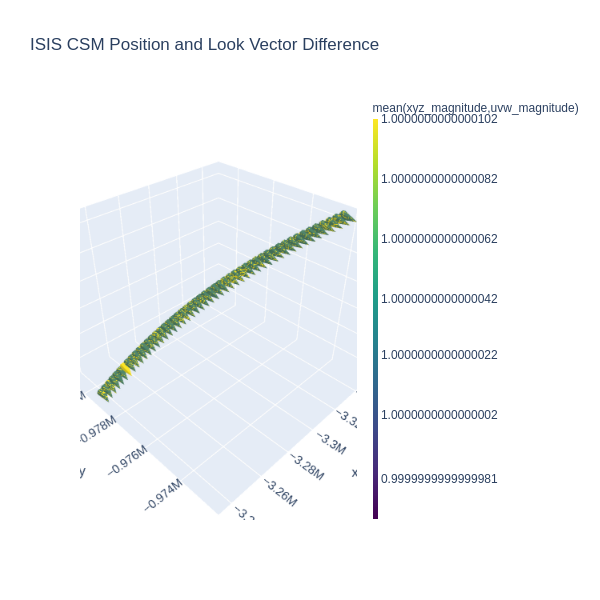

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

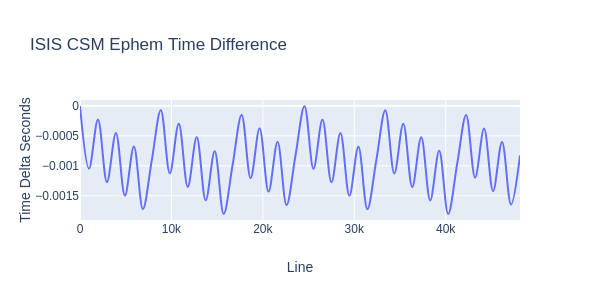

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,319.282791,91.223322,115.530759,-3.703806e-06,1.811224e-07,9.746793e-06
std,8.057742,1.255048,6.675095,2.233894e-06,2.229106e-07,5.880587e-06
min,304.279081,88.986325,102.553258,-7.771770e-06,-2.506653e-07,-4.163336e-15
25%,312.505867,90.140152,109.805774,-5.734157e-06,8.989059e-10,4.797146e-06
50%,319.302871,91.315302,115.868629,-3.618779e-06,1.419224e-07,9.821019e-06
75%,326.304220,92.294330,120.918982,-1.759892e-06,3.234053e-07,1.486457e-05
max,332.843829,93.241581,128.660091,1.998401e-15,6.874561e-07,1.963323e-05


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

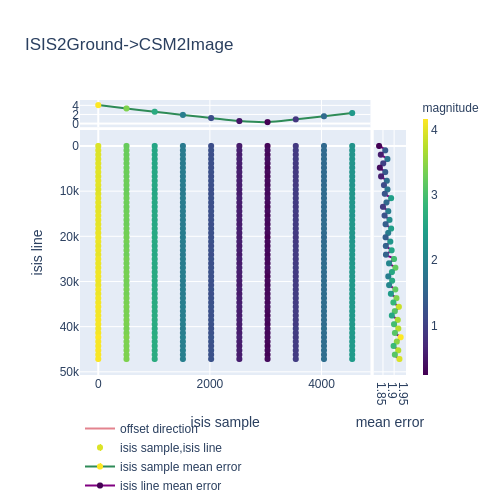

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.253116,0.852430
std,0.052605,2.016736
min,-0.360430,-2.360028
25%,-0.296283,-0.890906
50%,-0.252613,0.842825
75%,-0.214635,2.585693
max,-0.153320,4.153743


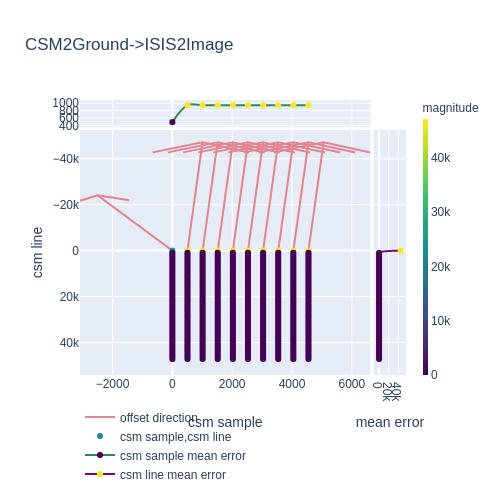

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-896.853520,3.244758
std,6362.133329,130.776950
min,-47165.213078,-2499.500000
25%,0.215193,-2.578644
50%,0.250413,-0.507837
75%,0.286573,0.898640
max,0.338801,507.232674


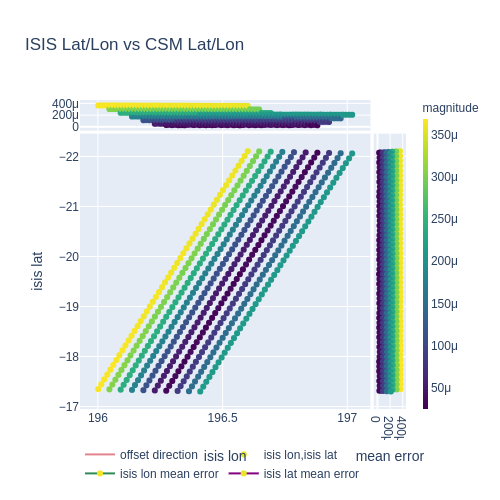

In [13]:
Image(isiscsm_plotlatlon.to_image())

In [14]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,500.000000,5.000000e+02
mean,0.000080,-1.687203e-05
std,0.000181,2.069170e-05
min,-0.000207,-5.686778e-05
25%,-0.000078,-3.425250e-05
50%,0.000080,-1.646465e-05
75%,0.000237,6.327228e-07
max,0.000368,2.372858e-05


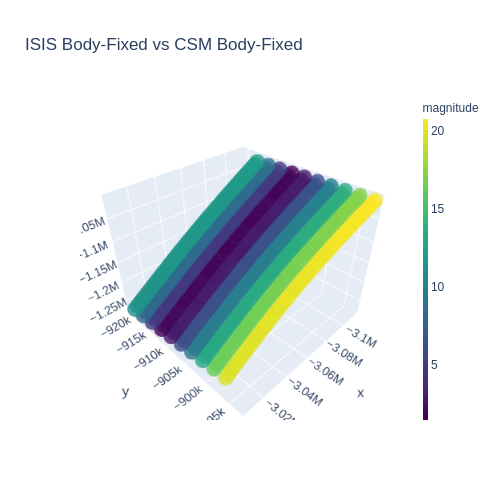

In [15]:
Image(isiscsm_plotbf.to_image())

In [16]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,1.113021,4.169445,0.939077
std,1.281710,9.786399,1.152158
min,-0.068251,-11.440884,-1.321705
25%,-0.002316,-4.365637,-0.034961
50%,0.227359,4.195624,0.921978
75%,2.728409,12.695085,1.911963
max,2.948791,20.011516,3.165163
